In [1]:
import os, glob, pickle, csv
import numpy as np
import torch, torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from skimage import io
import cv2 as cv
from tqdm import tqdm

/home/user01/miniconda3/envs/msrgcn/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user01/miniconda3/envs/msrgcn/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
os.environ.pop("CUDA_VISIBLE_DEVICES", None)  
print("torch:", torch.__version__)
print("compiled_with_cuda:", torch.version.cuda)
print("cuda.is_available:", torch.cuda.is_available())
print("device_count:", torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    try:
        print("Using GPU:", torch.cuda.get_device_name(0))
    except Exception:
        print("GPU visible but get_device_name failed (continuing).")
else:
    print("⚠ Running on CPU")


torch: 2.4.1
compiled_with_cuda: 12.1
cuda.is_available: True
device_count: 1
Using GPU: NVIDIA GeForce RTX 4090


In [3]:
torch.backends.cudnn.benchmark = torch.cuda.is_available()
AMP_DTYPE = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16

In [4]:
INPUT_DIR = '../data/VPC/multiscale_patches_Train/' 
EMB_OUT_PKL = "../data/VPC/patch_embeddings_avgpool.pkl"
SIM_MAT_OUT_NPY = "similarity_cosine.npy"
TOPK_CSV = "topk_neighbors.csv"

In [5]:
BATCH_SIZE = 128 if torch.cuda.is_available() else 32
IMG_SIZE   = 256
TOPK       = 10
NUM_CLASSES = 6 

In [6]:
def load_resnet18_pretrained(num_classes=NUM_CLASSES):
    """
    Pretrained ResNet18 (ImageNet). We only use avgpool embeddings.
    """
    weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
    model = torchvision.models.resnet18(weights=weights)
    model.fc = nn.Linear(512, num_classes, bias=True)  # FC not used for embeddings
    model = model.to(device).eval()
    if torch.cuda.is_available():
        model = model.to(memory_format=torch.channels_last)
    return model

In [13]:
_to_tensor = transforms.ToTensor()

def preprocess_np(img_np):
    if img_np.ndim == 2:
        img_np = cv.cvtColor(img_np, cv.COLOR_GRAY2RGB)
    if img_np.shape[2] == 4:
        img_np = img_np[:, :, :3]
    img_np = cv.resize(img_np, (IMG_SIZE, IMG_SIZE), interpolation=cv.INTER_CUBIC)
    t = _to_tensor(img_np)  # [3,H,W], float32
    return t  # <-- no channels_last here (it's 3D)


def iter_image_paths(root):
    return sorted(glob.glob(os.path.join(root, "**", "*.png"), recursive=True))

In [8]:
def build_avgpool_hook(model):
    activation = {}
    def hook(_, __, out):
        activation["avgpool"] = out
    layer = dict(model.named_modules())["avgpool"]
    handle = layer.register_forward_hook(hook)
    return activation, handle

In [15]:
@torch.no_grad()
def extract_embeddings(model, image_paths, batch_size=BATCH_SIZE):
    activation, handle = build_avgpool_hook(model)
    filenames, embs = [], []
    batch_imgs, batch_names = [], []

    def flush():
        if not batch_imgs:
            return
        batch = torch.stack(batch_imgs, 0).to(device, non_blocking=True)
        if torch.cuda.is_available():
            batch = batch.to(memory_format=torch.channels_last)
            use_amp = True
        else:
            use_amp = False

        if use_amp:
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
                _ = model(batch)
                out = activation["avgpool"]    # [B,512,1,1] or [B,512]
                out = torch.flatten(out, 1)    # [B,512]
        else:
            _ = model(batch)
            out = activation["avgpool"]
            out = torch.flatten(out, 1)

        embs.append(out.detach().to(torch.float32).cpu().numpy())
        filenames.extend(batch_names)
        batch_imgs.clear(); batch_names.clear()

    for p in tqdm(image_paths, desc="Embedding"):
        try:
            img = io.imread(p)
        except Exception as e:
            print(f"Skip read error: {p} ({e})"); continue
        batch_imgs.append(preprocess_np(img))
        batch_names.append(p)
        if len(batch_imgs) >= batch_size:
            flush()
    flush()
    handle.remove()
    E = np.concatenate(embs, 0) if embs else np.zeros((0,512), np.float32)
    return filenames, E

In [16]:
def cosine_similarity_matrix(E: np.ndarray) -> np.ndarray:
    if E.shape[0] == 0:
        return np.zeros((0,0), np.float32)
    norms = np.linalg.norm(E, axis=1, keepdims=True) + 1e-12
    En = E / norms
    S = En @ En.T
    return S.astype(np.float32)

In [17]:
def save_topk_neighbors_csv(files, S, k=TOPK, out_csv=TOPK_CSV):
    N = S.shape[0]
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["index","file","neighbor_index","neighbor_file","cosine_sim"])
        for i in range(N):
            idx = np.argsort(-S[i])
            idx = idx[idx != i][:k]
            for j in idx:
                w.writerow([i, files[i], j, files[j], f"{S[i,j]:.6f}"])

In [18]:
def main():
    # 1) collect images
    paths = iter_image_paths(INPUT_DIR)
    if not paths:
        print(f"No .png files found under: {INPUT_DIR}")
        return

    # 2) load model
    model = load_resnet18_pretrained()

    # optional sanity: confirm device
    try:
        print("Model device:", next(model.parameters()).device)
    except StopIteration:
        pass

    # 3) extract embeddings
    files, E = extract_embeddings(model, paths, batch_size=BATCH_SIZE)
    print("Embeddings:", E.shape)

    # 4) save embeddings
    with open(EMB_OUT_PKL, "wb") as f:
        pickle.dump({"files": files, "embeddings": E}, f)
    print("Saved:", EMB_OUT_PKL)

    # 5) compute & save similarity matrix
    S = cosine_similarity_matrix(E)
    np.save(SIM_MAT_OUT_NPY, S)
    print("Saved:", SIM_MAT_OUT_NPY, S.shape)

    # 6) save top‑k neighbors CSV
    save_topk_neighbors_csv(files, S, TOPK, TOPK_CSV)
    print("Saved top-k:", TOPK_CSV)

if __name__ == "__main__":
    main()

Model device: cuda:0


Embedding: 100%|██████████| 71244/71244 [18:04<00:00, 65.70it/s]  


Embeddings: (71244, 512)
Saved: ../data/VPC/patch_embeddings_avgpool.pkl
Saved: similarity_cosine.npy (71244, 71244)
Saved top-k: topk_neighbors.csv


In [20]:
import pickle
import numpy as np

# Load the saved embeddings
with open(EMB_OUT_PKL, "rb") as f:
    data = pickle.load(f)

files = data["files"]         # list of image file paths
embeddings = data["embeddings"]  # NumPy array of shape (N, 512)

print("Number of patches:", len(files))
print("Embedding shape:", embeddings.shape)  # (N, 512)

# Show first patch and its embedding
print("First file:", files[0])
print("First embedding vector:", embeddings[0])


Number of patches: 71244
Embedding shape: (71244, 512)
First file: ../data/VPC/multiscale_patches_Train/slide001_core003/512/10/0_0.png
First embedding vector: [3.20312500e-01 1.84570312e-01 1.40380859e-02 1.62500000e+00
 6.28906250e-01 2.34375000e-01 3.97949219e-02 7.66601562e-02
 3.32031250e-01 2.07031250e-01 5.15136719e-02 5.54687500e-01
 1.54418945e-02 1.07031250e+00 3.03955078e-02 6.91406250e-01
 4.16015625e-01 1.02343750e+00 0.00000000e+00 3.35693359e-04
 7.78198242e-03 1.96533203e-02 5.45501709e-04 2.51953125e-01
 1.85546875e-02 3.32031250e-01 1.42211914e-02 3.96484375e-01
 1.42578125e-01 3.17382812e-02 8.88671875e-02 5.78613281e-02
 5.31250000e-01 3.49609375e-01 1.53808594e-02 8.47656250e-01
 3.12500000e-01 4.12109375e-01 1.50781250e+00 0.00000000e+00
 7.89062500e-01 2.67578125e-01 5.82031250e-01 2.32812500e+00
 3.98437500e-01 7.93457031e-03 1.91406250e-01 2.48046875e-01
 1.20312500e+00 4.78515625e-01 9.21875000e-01 1.96289062e-01
 4.69970703e-03 0.00000000e+00 1.07031250e+00 5

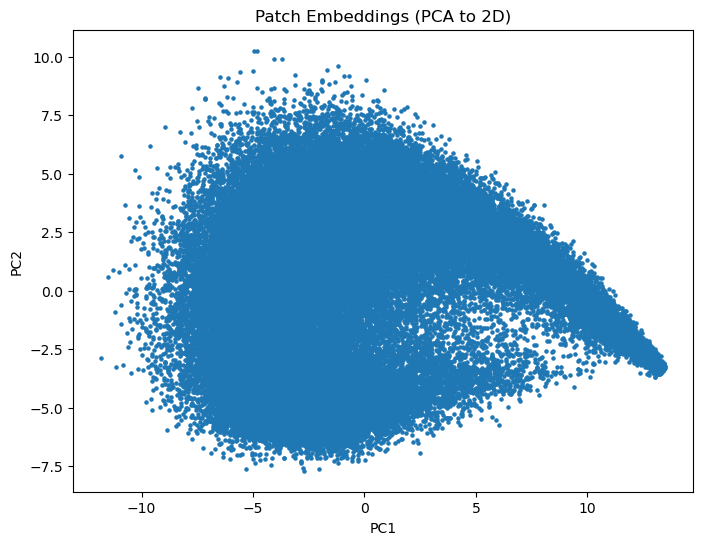

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce 512D → 2D with PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=5)
plt.title("Patch Embeddings (PCA to 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [22]:
import numpy as np

S = np.load("similarity_cosine.npy")
top_k = 5
i = 0  # index of the patch you want to check
neighbors = np.argsort(-S[i])[1:top_k+1]  # skip itself
print("Reference:", files[i])
print("Most similar patches:")
for n in neighbors:
    print(files[n], " (sim =", S[i, n], ")")


Reference: ../data/VPC/multiscale_patches_Train/slide001_core003/512/10/0_0.png
Most similar patches:
../data/VPC/multiscale_patches_Train/slide001_core083/512/10/0_0.png  (sim = 0.9481981 )
../data/VPC/multiscale_patches_Train/slide003_core080/512/10/0_0.png  (sim = 0.9462687 )
../data/VPC/multiscale_patches_Train/slide006_core130/512/10/0_0.png  (sim = 0.9394051 )
../data/VPC/multiscale_patches_Train/slide005_core033/512/10/0_0.png  (sim = 0.93879896 )
../data/VPC/multiscale_patches_Train/slide005_core097/512/10/0_0.png  (sim = 0.9386065 )


In [23]:
def save_embeddings_compat(model, imgs_path, embd_dir, embedding_layer, model_name, device):
    """
    imgs_path: list of full image paths (all from one core/mag/size directory)
    embd_dir:  base embeddings dir (e.g., '256_VPC_Zurich_embeddings_overlap/' + fold + '/')
    embedding_layer: 'avgpool'
    model_name: e.g., '256_aug_model'
    device: torch.device
    """
    # Build target file exactly like paper:
    # embd_dir + '/'.join(imgs_path[0].split('/')[-4:-1]) + '/' + model_name + '_' + embedding_layer + '.pkl'
    # (…/core/<size>/<mag>/)
    target_dir = os.path.join(embd_dir, *imgs_path[0].split('/')[-4:-1])
    os.makedirs(target_dir, exist_ok=True)
    target_path = os.path.join(target_dir, f"{model_name}_{embedding_layer}.pkl")
    if os.path.exists(target_path):
        return

    # Hook like paper
    activation = {}
    def hook_fn(_, __, out):
        activation[embedding_layer] = out
    handle = dict(model.named_modules())[embedding_layer].register_forward_hook(hook_fn)

    emb_dict = {}
    with torch.no_grad():
        for img_path in imgs_path:
            if not img_path.endswith('.png'):
                continue
            img = io.imread(img_path)
            if img.ndim == 2:
                img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
            if img.shape[2] == 4:
                img = img[:, :, :3]
            img = cv.resize(img, (256, 256), interpolation=cv.INTER_CUBIC)
            tens = transform(img).unsqueeze(0).to(device)
            _ = model(tens)  # forward to trigger hook
            out = activation[embedding_layer]           # [1,512,1,1] or [1,512]
            vec = torch.flatten(out, 1).squeeze(0)      # [512]
            emb_dict[os.path.basename(img_path)[:-4]] = vec.detach().cpu().numpy()

    handle.remove()
    with open(target_path, 'wb') as f:
        pickle.dump(emb_dict, f)